## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


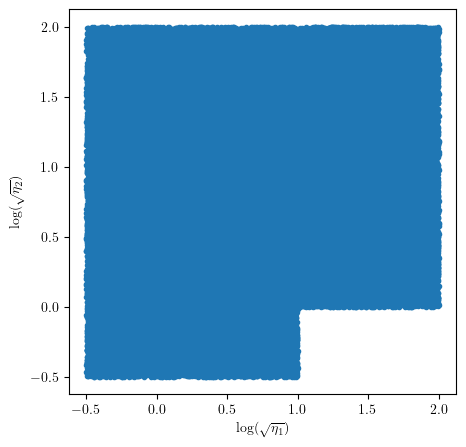

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([1.0, 2.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="exclude_area", eta_1_range=eta_1_range, eta_2_range=eta_2_range)

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [4]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

## Network Training

In [6]:
# Defining model parameters
checkpoint_dir = '../Model_Checkpoints/Ensemble/No_Rapid_Strain/'


net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 500,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
}

num_members = 40

In [7]:
test_criteria = RMSELoss()

for i in range(num_members):
    net_name = f'No_Rapid_Strain_Ens_{i}.pt'

    callbacks = [EarlyStopping(patience=15, threshold=0.000001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=net_name, dirname=checkpoint_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.000001, threshold_mode='abs', mode='min', verbose=True)
    ]
    train_params['callbacks'] = callbacks

    net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net = net.fit(x_train, y_train)

    net.load_params(f_params=checkpoint_dir+net_name)
    test_pred = net.predict(x_test)
    print(f"\t\tTest loss: {test_criteria(test_pred, y_test)}")



/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


		Test loss: 0.0042177592404186726
		Test loss: 0.0036595945712178946
		Test loss: 0.006674858741462231
		Test loss: 0.0029802718199789524
		Test loss: 0.004174603149294853
		Test loss: 0.004840228706598282
		Test loss: 0.0037588546983897686
		Test loss: 0.0077997129410505295
		Test loss: 0.003338365815579891
		Test loss: 0.004650278948247433
		Test loss: 0.002520456910133362
		Test loss: 0.0030487508047372103
		Test loss: 0.003681607311591506
		Test loss: 0.003606832353398204
		Test loss: 0.003748179879039526
		Test loss: 0.003565207589417696
		Test loss: 0.0027870102785527706
		Test loss: 0.0033139134757220745
		Test loss: 0.0037190078292042017
		Test loss: 0.005342456046491861
		Test loss: 0.003408054355531931
		Test loss: 0.004067640285938978
		Test loss: 0.0032132959458976984
		Test loss: 0.0043648164719343185
		Test loss: 0.004180683754384518
		Test loss: 0.003139690263196826
		Test loss: 0.0030319455545395613
		Test loss: 0.0032722684554755688
		Test loss: 0.004021746106445789
	

## Creating Ensemble

In [9]:
ensemble = []

for i in range(num_members):
    net = reinitialize_model(f'No_Rapid_Strain_Ens_{i}.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)


## Generating Statistics Data

tensor(5.8839e-05, dtype=torch.float64)


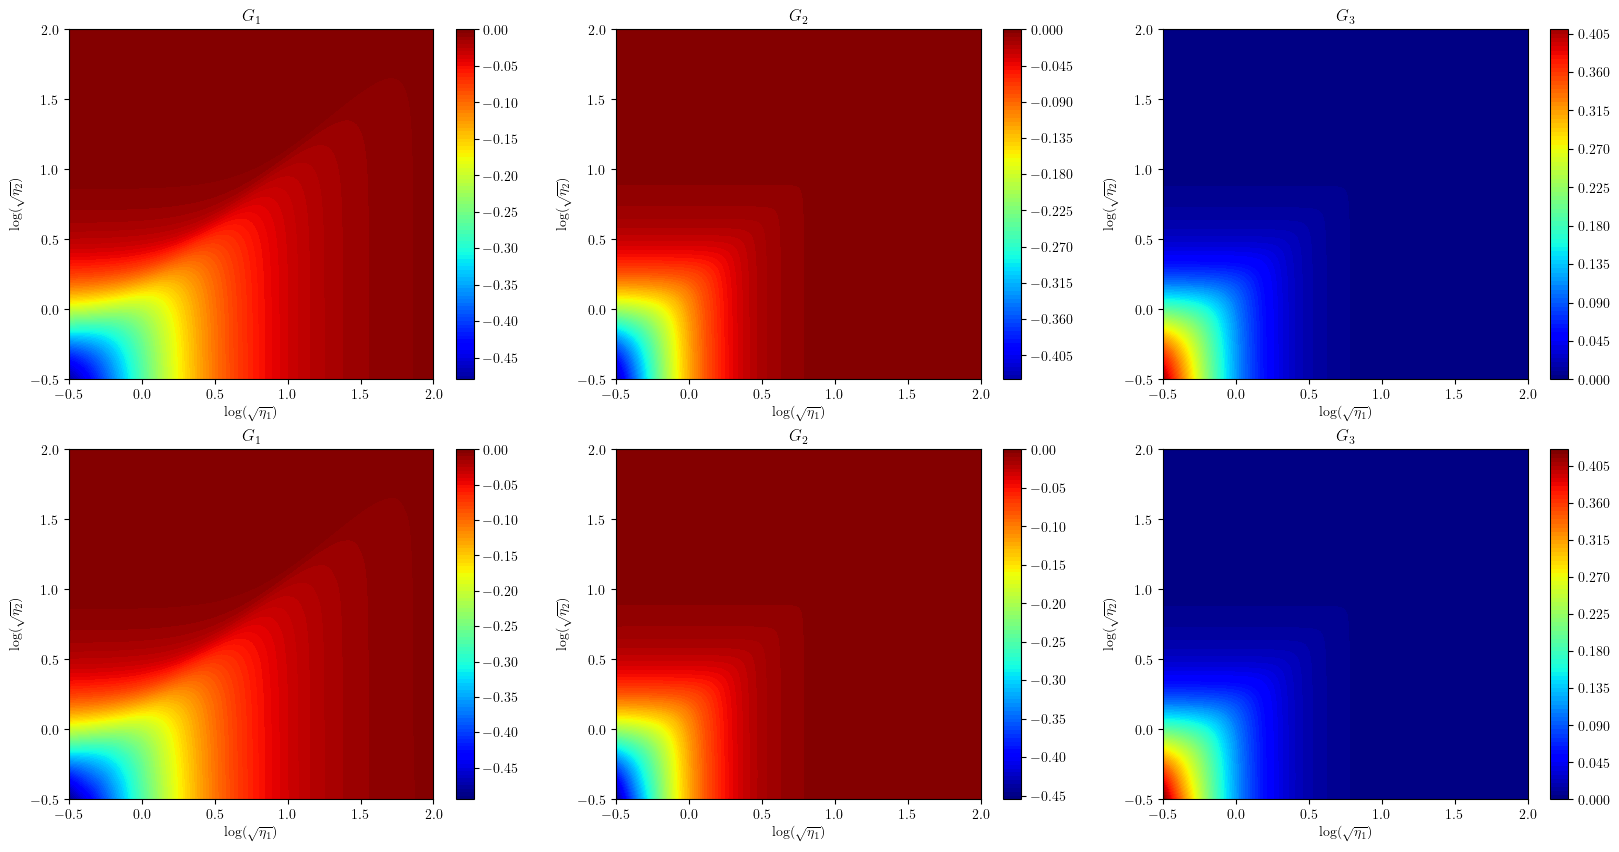

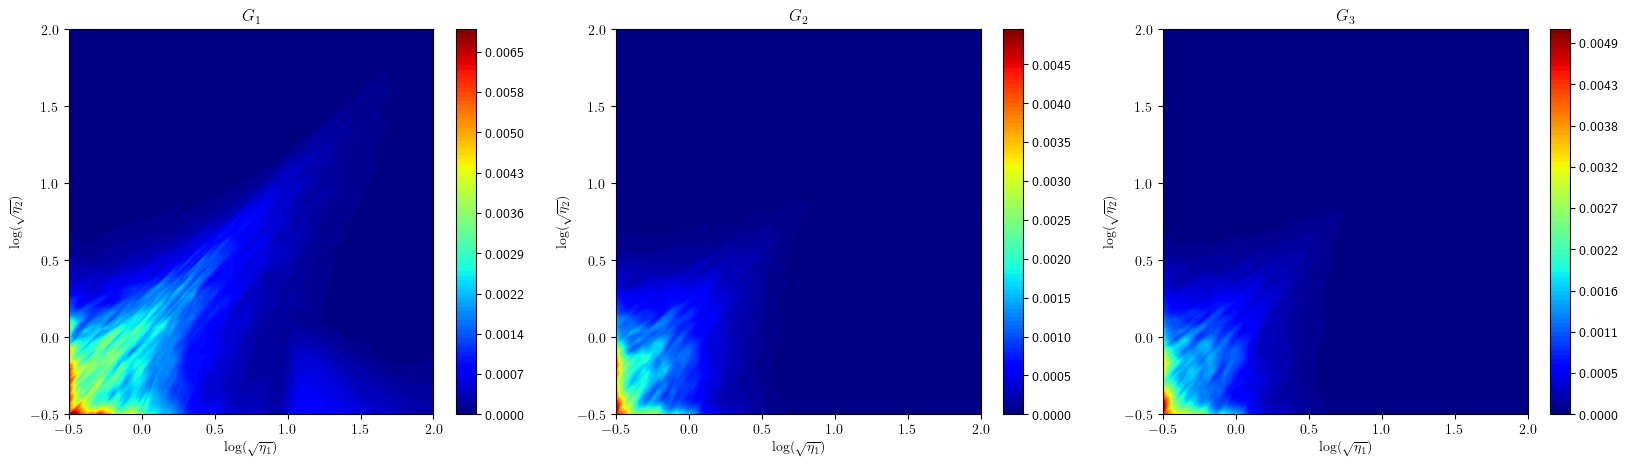

In [11]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))

for i in range(num_members):
    pred = ensemble[i].predict(etas.astype(np.float32))
    preds[i] = y_scaler.inverse_transform(pred)


pred = preds.mean(axis=0)

std = preds.std(axis=0)

np.savetxt('../data/Ensemble/No_Rapid_Pred_Mean.csv', pred, delimiter=',')
np.savetxt('../data/Ensemble/No_Rapid_Pred_Std.csv', std, delimiter=',')


print(torch.mean(torch.abs(torch.tensor(target) - pred.T.reshape(3, dim, dim))))

plot_heat_map_compare(x_grid, y_grid, target, pred.T.reshape(3, dim, dim), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

plot_heat_map_3D(x_grid, y_grid, old_std, "Ensemble Standard Deviation", sup_title=False)

In [ ]:
old_std = np.loadtxt('../data/Ensemble/Pred_Std.csv', delimiter=',')
new_std = np.loadtxt('../data/Ensemble/No_Rapid_Pred_Std.csv', delimiter=',')

plot_heat_map_3D(x_grid, y_grid, new_std, "Ensemble Standard Deviation", sup_title=False)
plot_heat_map_3D(x_grid, y_grid, old_std, "Ensemble Standard Deviation", sup_title=False)

## Visualizing Functions

In [17]:
predictions = []
for member in ensemble:
    predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

predictions.append(y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1))

vis_outputs = np.concatenate(predictions, axis=0)

Calculating PHATE...
  Running PHATE on 21 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/codygrogan/.local/lib/python3.12/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (21, 2400) is expensive. Consider setting n_pca.
  warnings.warn(


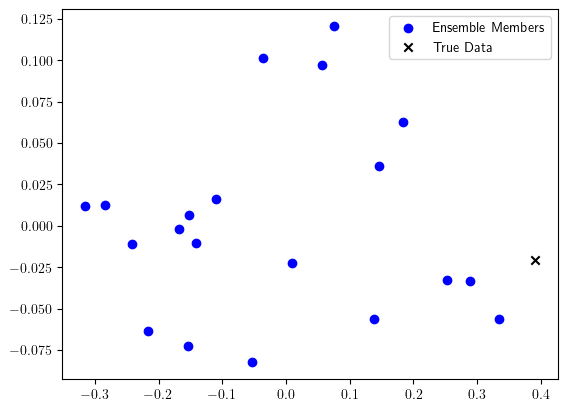

In [19]:
from phate import PHATE

phate = PHATE(n_components=2, n_jobs=4)

embedding = phate.fit_transform(vis_outputs)

plt.scatter(embedding[:-1, 0], embedding[:-1, 1], c='b', label='Ensemble Members')

plt.scatter(embedding[-1, 0], embedding[-1, 1], c='black', marker='x', label='True Data')

plt.legend()
plt.show()